# MLP classification

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

from src.utils.viz import *

In [2]:
# Read & split train test
filename = './data/clean_entire_corpus.csv'
df = pd.read_csv(filename)
df_train = df[df['source'] == 'train'].copy()
df_test = df[df['source'] == 'test'].copy()

## Data preprocessing

In [3]:
# Encoding
def get_vocabulary(iter_sents):
    vocab = set()
    max_length = 0
    for text in iter_sents:
        tokens = text.split(' ')
        if len(tokens) > max_length:
            max_length = len(tokens)
        vocab.update(tokens)
    return vocab, max_length

vocab, max_length = get_vocabulary(df_train['clean_text'])

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
sequences_train = tokenizer.texts_to_sequences(df_train['clean_text'])
sequences_test = tokenizer.texts_to_sequences(df_test['clean_text'])

In [4]:
# Padding
padded_seqs_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_length,
                                                            padding='post', truncating='post')
padded_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_length,
                                                            padding='post', truncating='post')

In [5]:
# Data sets
X_train = padded_seqs_train
X_test = padded_seqs_test
y_train = df_train['target'].values
y_test = df_test['target'].values

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

In [6]:
# Build an index for embeddings
embeddings_index = {}
EMBEDDINGS_PATH = '/datascience/embeddings'
EMBEDDINGS_LENGTH = 50
print('Reading lines')
with open(os.path.join(EMBEDDINGS_PATH, 'glove.6B.50d.txt'), encoding='utf-8') as f:
    lines = f.readlines()

print('Extract embeddings')
for line in lines:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Create embeddings matrix')
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDINGS_LENGTH))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Reading lines
Extract embeddings
Create embeddings matrix


## Training model

In [20]:
model = tf.keras.Sequential()
model.add(a := tf.keras.layers.Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDINGS_LENGTH,
                                         input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(b := tf.keras.layers.Conv1D(filters=200, kernel_size=3))
model.add(c := tf.keras.layers.MaxPool1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(h := tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

EPOCHS = 80
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/80
69/69 [==============================] - 2s 28ms/step - loss: 0.6759 - acc: 0.5803 - val_loss: 0.6660 - val_acc: 0.6044
Epoch 2/80
69/69 [==============================] - 2s 24ms/step - loss: 0.6430 - acc: 0.6516 - val_loss: 0.6380 - val_acc: 0.6614
Epoch 3/80
69/69 [==============================] - 2s 24ms/step - loss: 0.6151 - acc: 0.6982 - val_loss: 0.6127 - val_acc: 0.7067
Epoch 4/80
69/69 [==============================] - 2s 24ms/step - loss: 0.5898 - acc: 0.7307 - val_loss: 0.5900 - val_acc: 0.7263
Epoch 5/80
69/69 [==============================] - 2s 24ms/step - loss: 0.5675 - acc: 0.7493 - val_loss: 0.5711 - val_acc: 0.7337
Epoch 6/80
69/69 [==============================] - 2s 24ms/step - loss: 0.5476 - acc: 0.7598 - val_loss: 0.5543 - val_acc: 0.7453
Epoch 7/80
69/69 [==============================] - 2s 25ms/step - loss: 0.5316 - acc: 0.7686 - val_loss: 0.5417 - val_acc: 0.7518
Epoch 8/80
69/69 [==============================] - 2s 24ms/step - loss: 0.5190 - a

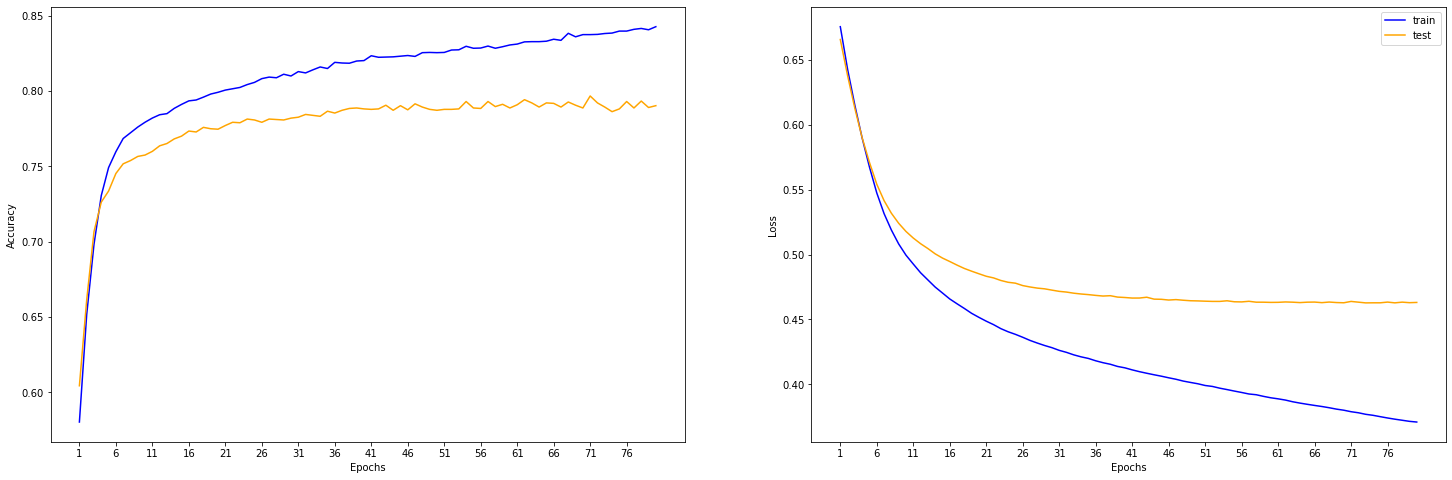

In [27]:
epochs = range(1, EPOCHS+1)
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

axs[0].plot(epochs, history.history['acc'], color='blue', label='train')
axs[0].plot(epochs, history.history['val_acc'], color='orange', label='test')
axs[0].set_xticks(range(1, EPOCHS+1, 5))
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(epochs, history.history['loss'], color='blue', label='train')
axs[1].plot(epochs, history.history['val_loss'], color='orange', label='test')
axs[1].set_xticks(range(1, EPOCHS+1, 5))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
plt.legend()

* The best score reaches 0.79 of accuracy

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x294be6c9400>)

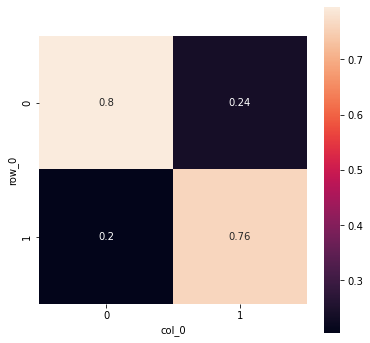

In [9]:
y_pred = model.predict(X_test).reshape(1, -1)[0]
y_pred = np.around(y_pred).astype(int)

plot_confusion_matrix(y_test, y_pred)

In [10]:
df_test['pred'] = y_pred
model_errors = df_test[df_test['pred'] != df_test['target']]
model_errors

,id,keyword,text,target,source,clean_text,pred
6861,70,ablaze,Burning Man Ablaze! by Turban Diva http://t.co...,0,test,burning man ablaze by turban diva via,1
6864,84,ablaze,SETTING MYSELF ABLAZE http://t.co/6vMe7P5XhC,0,test,setting myself ablaze,1
6868,94,ablaze,@PhilippaEilhart @DhuBlath hurt but her eyes a...,0,test,hurt but her eyes ablaze with insulted anger,1
6870,101,accident,Just got to love burning your self on a damn c...,0,test,just got to love burning your self on a damn c...,1
6871,103,accident,I hate badging shit in accident,0,test,i hate badging shit in accident,1
...,...,...,...,...,...,...,...
10087,10806,wrecked,RT CNBC '3 words from Disney CEO Bob Iger wrec...,1,test,rt cnbc words from disney ceo bob iger wrecked...,0
10088,10807,wrecked,Smackdown tyme this should put me in a good mo...,0,test,smackdown tyme this should put me in a good mo...,1
10096,10857,NaN,To conference attendees! The blue line from th...,1,test,to conference attendees the blue line from the...,0
10098,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0,test,earthquake safety los angeles safety fasteners...,1


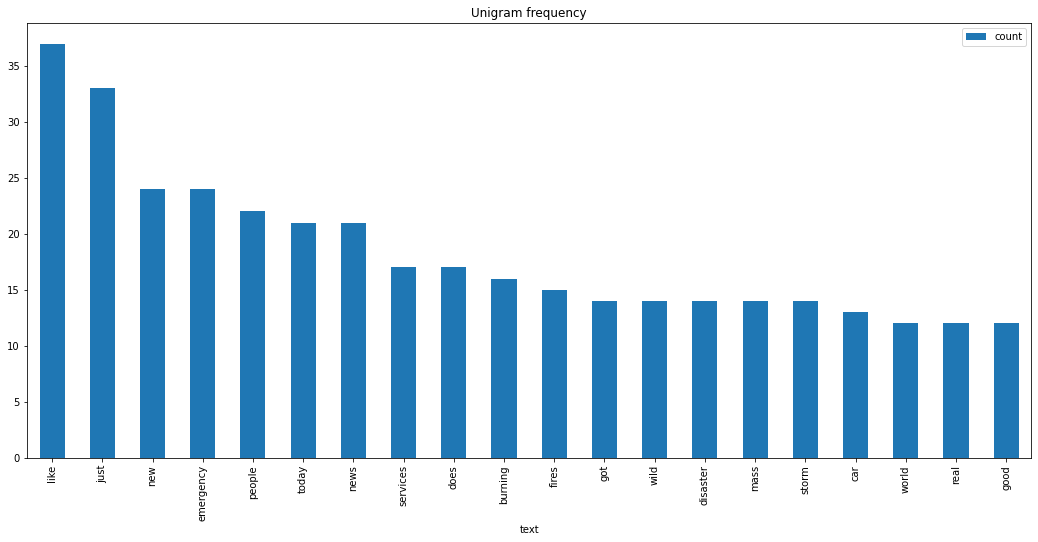

In [11]:
top_unigrams = get_top_grams(model_errors['clean_text'], 20)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_unigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Unigram frequency')

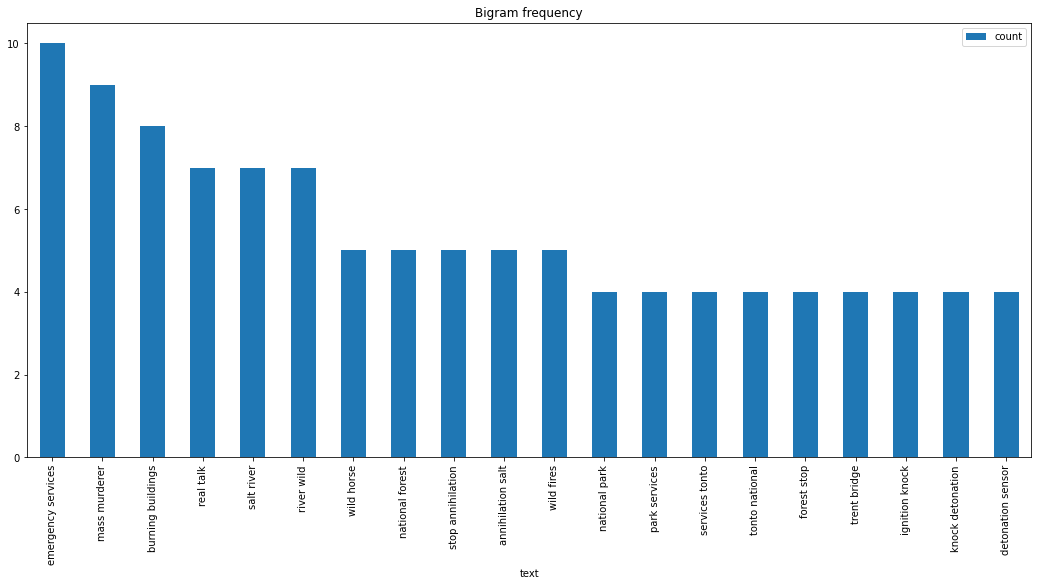

In [12]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=2)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Bigram frequency')

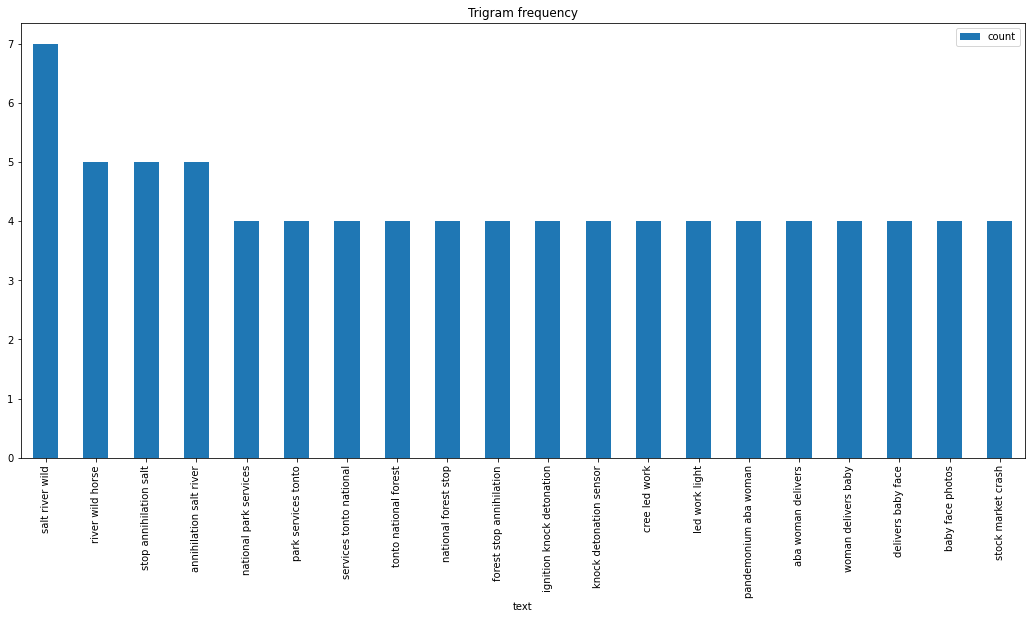

In [13]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=3)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Trigram frequency')